In [139]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
from scipy import optimize
from scipy.stats import gaussian_kde

Read catalog with Gaia DR2 data for the SDSS Stripe 82 region, see

https://github.com/dirac-institute/ivezic/blob/master/GaiaSprintUW2018/getStripe82fromGaiaDR2.ipynb


In [2]:
colnames = ['ra', 'dec', 'nObs', 'Gmag', 'flux', 'fluxErr', 'pmra', 'pmdec']
#gaia = Table.read('Stripe82_GaiaDR2.dat', format='ascii', names=colnames)
# developed code using Stripe82_GaiaDR2_1percent.dat
# a 1% subsample produced with
# cat Stripe82_GaiaDR2.dat | awk 'BEGIN {srand()} !/^$/ { if (rand() <= .01) print $0}' > Stripe82_GaiaDR2_1percent.dat
gaia = Table.read('Stripe82_GaiaDR2_1percent.dat', format='ascii', names=colnames)

Make a few sanity plots to ensure all is kosher...

In [3]:
# make more sanity plots 
def makeStripe82GaiaDR2plots(Stripe82data):
    """Make a six-panel plot illustrating Gaia DR2 data for SDSS Stripe82"""

    ra = Stripe82data['ra']
    dec = Stripe82data['dec']
    nobs = Stripe82data['nObs']
    Gmag = Stripe82data['Gmag']
    flux = Stripe82data['flux']
    fluxErr = Stripe82data['fluxErr']
    # user wrapped RA to avoid disjoint regions 
    raW = np.where(ra > 180, ra-360, ra)
     
    ### PLOTTING ###
    plot_kwargs = dict(color='k', linestyle='none', marker='.', markersize=1)
    plt.subplots_adjust(bottom=0.15, top=0.9, left=0.15, right=0.98, wspace=0.4, hspace=0.4)

    hist, bins = np.histogram(dec, bins=50)
    center = (bins[:-1]+bins[1:])/2
    ax2 = plt.subplot(2,1,1)
    ax2.plot(center, hist, drawstyle='steps')   
    ax2.set_xlim(-1.3, 1.3)
    # ax2.set_ylim(0, 20000)
    ax2.set_xlabel(r'$\mathrm{Dec (deg)}$')
    ax2.set_ylabel(r'$\mathrm{dN/dDec}$')

    hist, bins = np.histogram(Gmag, bins=50)
    center = (bins[:-1]+bins[1:])/2
    ax3 = plt.subplot(2,1,2)
    ax3.plot(center, hist, drawstyle='steps')   
    ax3.set_xlim(12, 22)
    ax3.set_xlabel(r'$\mathrm{Gmag}$')
    ax3.set_ylabel(r'$\mathrm{dN/dGmag}$')
   
    plt.savefig('Stripe82GaiaDR2plots2.png')
    plt.show() 

    return 

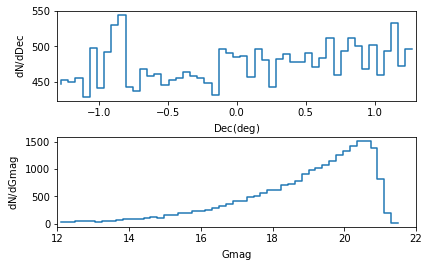

In [4]:
makeStripe82GaiaDR2plots(gaia)

In [9]:
def plot2Dmap(x, y, xMin, xMax, nXbin, yMin, yMax, nYbin, xLabel, yLabel, logScale=False):

    data = np.vstack([x, y])
    kde = gaussian_kde(data)

    # evaluate on a regular grid
    xgrid = np.linspace(xMin, xMax, nXbin)
    ygrid = np.linspace(yMin, yMax, nYbin)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))
    # plot the result as an image
    if (logScale):
        plt.imshow(Z.reshape(Xgrid.shape),
               origin='lower', aspect='auto',
               extent=[xMin, xMax, yMin, yMax],
               cmap='Blues', 
               norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()))
        cb = plt.colorbar()
        cb.set_label("density on log scale")
    else: 
        plt.imshow(Z.reshape(Xgrid.shape),
               origin='lower', aspect='auto',
               extent=[xMin, xMax, yMin, yMax],
               cmap='Blues') 
        cb = plt.colorbar()
        cb.set_label("density on lin scale")

    plt.xlabel(xLabel)
    plt.ylabel(yLabel)

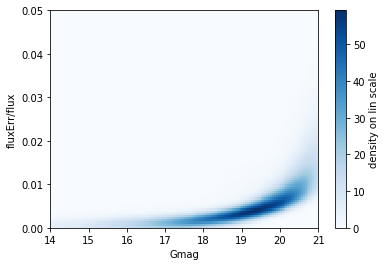

In [10]:
flux = gaia['flux']
fluxErr = gaia['fluxErr']
relFerr = fluxErr/flux 
Gmag = gaia['Gmag'] 
plot2Dmap(Gmag, relFerr, 14, 21, 140, 0, 0.05, 100, 'Gmag', 'fluxErr/flux')

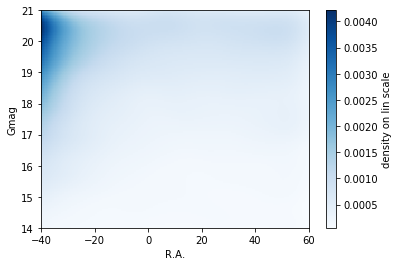

In [13]:
ra = gaia['ra']
# user wrapped RA to avoid disjoint regions 
raW = np.where(ra > 180, ra-360, ra)   
Gmag = gaia['Gmag'] 
plot2Dmap(raW, Gmag, -40, 60, 240, 14, 21, 140, 'R.A.', 'Gmag')

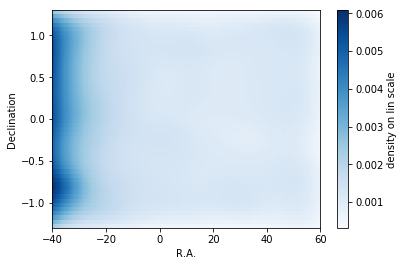

In [14]:
dec = gaia['dec'] 
plot2Dmap(raW, dec, -40, 60, 240, -1.3, 1.3, 52, 'R.A.', 'Declination')

Read SDSS Stripe82 Standard Star Catalog, see
http://faculty.washington.edu/ivezic/sdss/catalogs/stripe82.html

In [15]:
colnames = ['calib_fla', 'ra', 'dec', 'raRMS', 'decRMS', 'nEpochs', 'AR_val', 
                'u_Nobs', 'u_mMed', 'u_mMean', 'u_mErr', 'u_rms_scatt', 'u_chi2',
                'g_Nobs', 'g_mMed', 'g_mMean', 'g_mErr', 'g_rms_scatt', 'g_chi2',
                'r_Nobs', 'r_mMed', 'r_mMean', 'r_mErr', 'r_rms_scatt', 'r_chi2',
                'i_Nobs', 'i_mMed', 'i_mMean', 'i_mErr', 'i_rms_scatt', 'i_chi2',
                'z_Nobs', 'z_mMed', 'z_mMean', 'z_mErr', 'z_rms_scatt', 'z_chi2']

sdss = Table.read('stripe82calibStars_v2.6.dat', format='ascii', names=colnames)

Match Gaia to SDSS, since here SDSS is much larger 

In [60]:
sdss_coords = SkyCoord(ra = sdss['ra']*u.degree, dec= sdss['dec']*u.degree) 
gaia_coords = SkyCoord(ra = gaia['ra']*u.degree, dec= gaia['dec']*u.degree) 

# this is matching gaia to sdss, so that indices are into sdss catalog
# makes sense in this case since the sdss catalog is bigger than gaia
idx, d2d, d3d = gaia_coords.match_to_catalog_sky(sdss_coords)  

# object separation is an object with units, 
# I add that as a column so that one can 
# select based on separation to the nearest matching object
gaia_sdss = hstack([gaia, sdss[idx]], table_names = ['gaia', 'sdss'])
gaia_sdss['sep_2d_arcsec'] = d2d.arcsec

# since it's matching gaia to sdss,
# the resulting catalog has the same length 
# as gaia ... 

In [61]:
dra = 3600*(gaia_sdss['ra_sdss'] - gaia_sdss['ra_gaia']) 
ddec = 3600*(gaia_sdss['dec_sdss'] - gaia_sdss['dec_gaia'])  

Select good matches

-0.0475918927052
0.205694063261


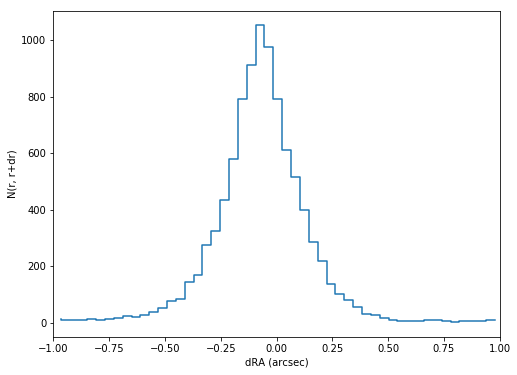

In [63]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
draOK = dra[(dra>-1.0)&(dra<1.0)]
print(np.median(draOK))
print(np.std(draOK))
hist, bins = np.histogram(draOK, bins=50)
center = (bins[:-1]+bins[1:])/2
ax.plot(center, hist, drawstyle='steps')   
ax.set_xlabel('dRA (arcsec)')
ax.set_ylabel('N(r, r+dr)')
ax.set_xlim(-1.0, 1.0)
plt.show()

0.075747299168
0.145850412967


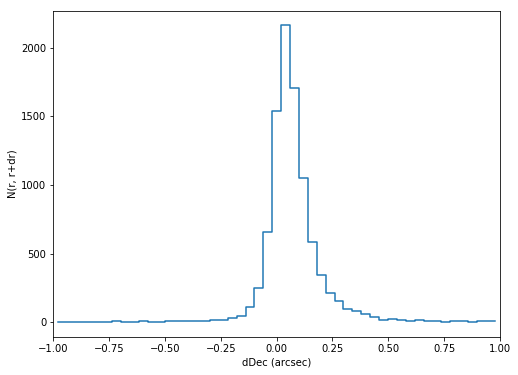

In [64]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ddecOK = ddec[(ddec>-1)&(ddec<1)]
print(np.median(ddecOK))
print(np.std(ddecOK))
hist, bins = np.histogram(ddecOK, bins=50)
center = (bins[:-1]+bins[1:])/2
ax.plot(center, hist, drawstyle='steps')   
ax.set_xlabel('dDec (arcsec)')
ax.set_ylabel('N(r, r+dr)')
ax.set_xlim(-1, 1)
plt.show()

In [65]:
# I would call good match to be within a certain limit 
# there is no built-in boundary - match_to_catalog_sky()
# will find the nearest match, regardless if it's an arcsecond
# or five degrees to the nearest one.

# gaia sources that have a good sdss match 
flag = (gaia_sdss['sep_2d_arcsec'] < 0.5)  # 486812 for <1 arcsec
gaia_matched = gaia_sdss[flag]
print(len(gaia_sdss))
print(len(gaia_matched))

23715
8877


-0.0450989716228
0.16005352817
0.0744214954357
0.0902704429646
-0.494811184308
0.481554711678


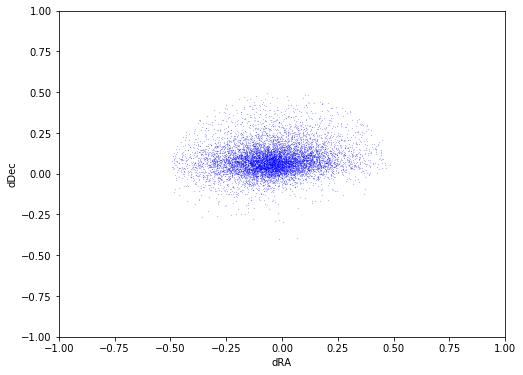

In [66]:
dra = 3600*(gaia_matched['ra_sdss'] - gaia_matched['ra_gaia']) 
ddec = 3600*(gaia_matched['dec_sdss'] - gaia_matched['dec_gaia'])  
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(dra, ddec, s=0.01, c='blue')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_xlabel('dRA')
ax.set_ylabel('dDec')
print(np.median(dra))
print(np.std(dra))
print(np.median(ddec))
print(np.std(ddec))
print(np.min(dra))
print(np.max(dra))

Text(0,0.5,'r')

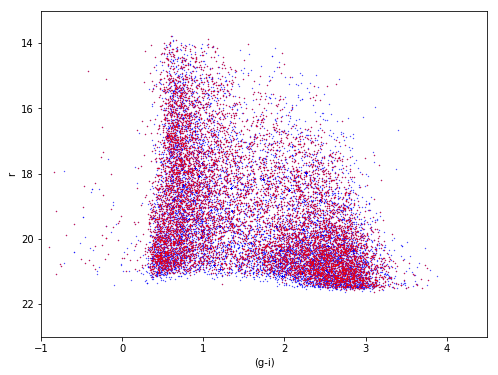

In [68]:
gi = gaia_matched['g_mMed'] - gaia_matched['i_mMed']
giAll = gaia_sdss['g_mMed'] - gaia_sdss['i_mMed']
r = gaia_matched['r_mMed']
rAll = gaia_sdss['r_mMed']
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(giAll, rAll, s=0.01, c='blue')
ax.scatter(gi, r, s=0.01, c='red')
ax.set_xlim(-1,4.5)
ax.set_ylim(23,13)
ax.set_xlabel('(g-i)')
ax.set_ylabel('r')

Text(0,0.5,'r')

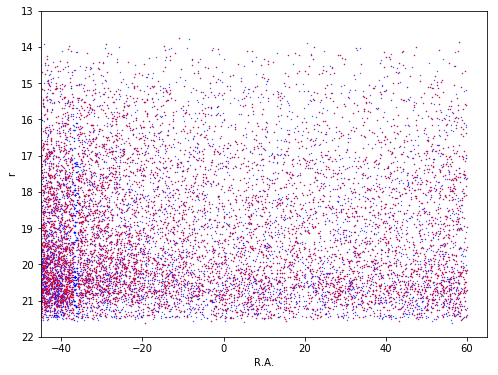

In [69]:
r = gaia_matched['r_mMed']
rAll = gaia_sdss['r_mMed']
ra = gaia_matched['ra_sdss'] 
raW = np.where(ra > 180, ra-360, ra)
raA = gaia_sdss['ra_gaia'] 
raAW = np.where(raA > 180, raA-360, raA)

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(raAW, rAll, s=0.01, c='blue')
ax.scatter(raW, r, s=0.01, c='red')
ax.set_xlim(-45,65)
ax.set_ylim(22,13)
ax.set_xlabel('R.A.')
ax.set_ylabel('r')

Text(0,0.5,'Dec')

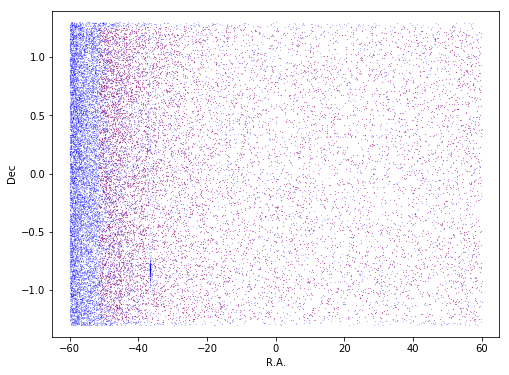

In [70]:
dec = gaia_matched['dec_gaia']
decA = gaia_sdss['dec_gaia']
ra = gaia_matched['ra_gaia'] 
raW = np.where(ra > 180, ra-360, ra)
raA = gaia_sdss['ra_gaia'] 
raAW = np.where(raA > 180, raA-360, raA)

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(raAW, decA, s=0.01, c='blue')
ax.scatter(raW, dec, s=0.01, c='red')
ax.set_xlim(-65,65)
ax.set_ylim(-1.4,1.4)
ax.set_xlabel('R.A.')
ax.set_ylabel('Dec')

In [36]:
rMed = gaia_matched['r_mMed'] 
# flagOK = ((raW > -10) & (raW < 50) & (rMed>15) & (rMed<20))
# flagOK = ((raW > -10) & (raW < 50) & (rMed>16) & (rMed<19))
flagOK = ((raW > -10) & (raW < 50) & (rMed>16) & (rMed<19) & (gi>0) & (gi<3.0))
gaia_matchedOK = gaia_matched[flagOK]
print(len(gaia_matchedOK))

912


Text(0,0.5,'SDSS(r-i)')

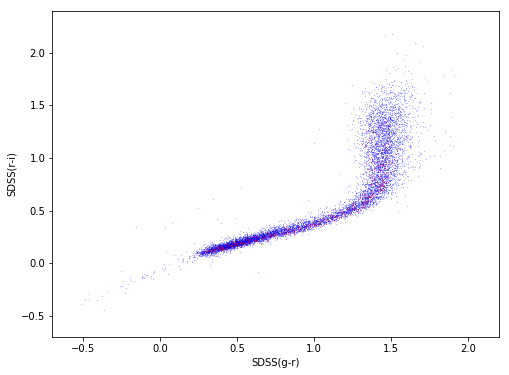

In [73]:
gr = gaia_matched['g_mMed'] - gaia_matched['r_mMed']
ri = gaia_matched['r_mMed'] - gaia_matched['i_mMed']
grOK = gaia_matchedOK['g_mMed'] - gaia_matchedOK['r_mMed']
riOK = gaia_matchedOK['r_mMed'] - gaia_matchedOK['i_mMed']
# plot
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(gr, ri, s=0.01, c='blue')
ax.scatter(grOK, riOK, s=0.01, c='red')
ax.set_xlim(-0.7,2.2)
ax.set_ylim(-0.7,2.4)
ax.set_xlabel('SDSS(g-r)')
ax.set_ylabel('SDSS(r-i)')